In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from keras.preprocessing.image import img_to_array
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SIZE = 320

In [ ]:

clean_data=[]
path = '/content/drive/MyDrive/DIV2K_train_HR'
files=os.listdir(path)
for i in tqdm(files):
    img=cv2.imread(path+'/'+i,1)
    img=cv2.resize(img,(SIZE, SIZE))
    clean_data.append(img_to_array(img))

100%|██████████| 800/800 [05:01<00:00,  2.66it/s]


In [ ]:
def add_gaussian_noise(image, mean=0, stddev=50):

    noise = np.random.normal(mean, stddev, image.shape).astype(image.dtype)

    noisy_image = cv2.add(image, noise)

    return noisy_image


noisy_data = []

for img in clean_data:
    noisy_img = add_gaussian_noise(img, stddev=50)  # Set noise level to 50
    noisy_data.append(noisy_img)


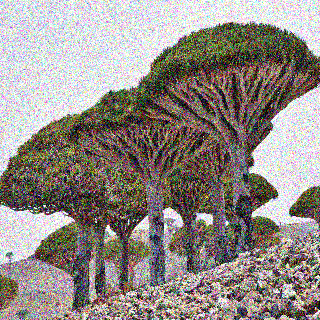

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

cv2_imshow(noisy_data[1])


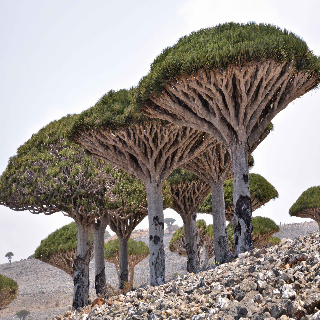

In [ ]:
cv2_imshow(clean_data[1])

In [ ]:
noisy_train = np.reshape(noisy_data, (len(noisy_data), SIZE, SIZE, 3))
noisy_train = noisy_train.astype('float32') / 255.

clean_train = np.reshape(clean_data, (len(clean_data), SIZE, SIZE, 3))
clean_train = clean_train.astype('float32') / 255.


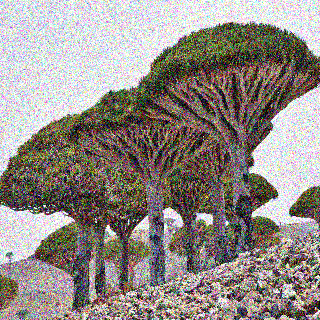

In [ ]:
cv2_imshow(noisy_data[1])

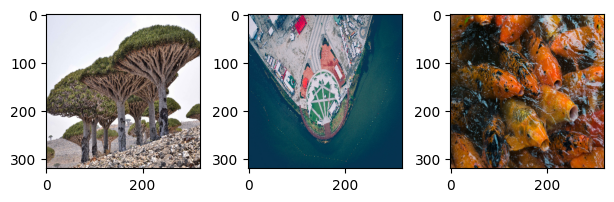

In [ ]:
plt.figure(figsize=(10, 2))
for i in range(1,4):
    ax = plt.subplot(1, 4, i)
    image_rgb = cv2.cvtColor(clean_train[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb.reshape(SIZE, SIZE,3))
plt.show()

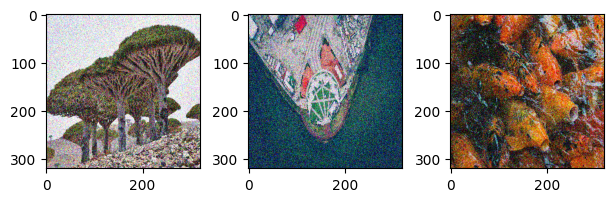

In [ ]:
plt.figure(figsize=(10, 2))
for i in range(1,4):
    ax = plt.subplot(1, 4, i)
    image_rgb = cv2.cvtColor(noisy_train[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb.reshape(SIZE, SIZE,3))
plt.show()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))


model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

In [ ]:
import tensorflow as tf
def psnr(y_true, y_pred):
    max_pixel = 1.0
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(-3, -2, -1))
    psnr = 20 * tf.math.log(max_pixel / tf.sqrt(mse)) / tf.math.log(10.0)
    return tf.reduce_mean(psnr)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[psnr])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 320, 320, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 160, 160, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 8)       2312      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 80, 80, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 8)         584       
                                                                 
 up_sampling2d (UpSampling2  (None, 160, 160, 8)       0

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(noisy_train, clean_train,
                                                    test_size = 0.20, random_state = 0)

In [ ]:
model.fit(x_train, y_train, epochs=10, batch_size=4, shuffle=True, verbose = 1,
          validation_split = 0.1)


Epoch 1/10
144/144 [==============================] - 11s 27ms/step - loss: 0.0381 - psnr: 15.9539 - val_loss: 0.0167 - val_psnr: 18.3047
Epoch 2/10
144/144 [==============================] - 3s 21ms/step - loss: 0.0146 - psnr: 18.9685 - val_loss: 0.0133 - val_psnr: 19.3482
Epoch 3/10
144/144 [==============================] - 3s 21ms/step - loss: 0.0127 - psnr: 19.5829 - val_loss: 0.0125 - val_psnr: 19.5963
Epoch 4/10
144/144 [==============================] - 3s 24ms/step - loss: 0.0122 - psnr: 19.8134 - val_loss: 0.0121 - val_psnr: 19.7762
Epoch 5/10
144/144 [==============================] - 3s 21ms/step - loss: 0.0119 - psnr: 19.9406 - val_loss: 0.0117 - val_psnr: 19.9030
Epoch 6/10
144/144 [==============================] - 3s 20ms/step - loss: 0.0114 - psnr: 20.1159 - val_loss: 0.0111 - val_psnr: 20.1473
Epoch 7/10
144/144 [==============================] - 3s 21ms/step - loss: 0.0109 - psnr: 20.2977 - val_loss: 0.0108 - val_psnr: 20.2475
Epoch 8/10
144/144 [====================

In [ ]:
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(x_test), np.array(y_test))[1]*100))


5/5 [==============================] - 2s 67ms/step - loss: 0.0120 - psnr: 19.7759
Test_Accuracy: 1977.59%


In [ ]:
no_noise_img = model.predict(x_test)

5/5 [==============================] - 1s 34ms/step


In [ ]:
no_noise_img[0]

array([[[0.43417937, 0.52687615, 0.43679276],
        [0.5545655 , 0.6074988 , 0.63100356],
        [0.60026884, 0.60484844, 0.521747  ],
        ...,
        [0.5511447 , 0.62676334, 0.6588317 ],
        [0.5858614 , 0.61554563, 0.6341088 ],
        [0.5759526 , 0.5995558 , 0.5340669 ]],

       [[0.7462947 , 0.6753683 , 0.7115037 ],
        [0.7054809 , 0.65649027, 0.7661124 ],
        [0.66717273, 0.6350132 , 0.6797203 ],
        ...,
        [0.57562083, 0.581403  , 0.72419286],
        [0.5717747 , 0.5760007 , 0.6294511 ],
        [0.584105  , 0.56293106, 0.63254344]],

       [[0.7716893 , 0.66875684, 0.6563651 ],
        [0.7168185 , 0.70298696, 0.77794117],
        [0.65303814, 0.69921017, 0.7172261 ],
        ...,
        [0.56938183, 0.57992727, 0.68169856],
        [0.5933858 , 0.5784851 , 0.65986454],
        [0.633375  , 0.58854413, 0.56405276]],

       ...,

       [[0.43061316, 0.6834136 , 0.645736  ],
        [0.46661508, 0.7311513 , 0.780008  ],
        [0.5373008 , 0

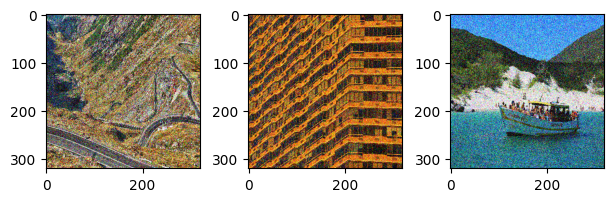

In [ ]:
plt.figure(figsize=(10, 2))
for i in range(1,4):
    ax = plt.subplot(1, 4, i)
    image_rgb = cv2.cvtColor(x_test[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb.reshape(SIZE, SIZE,3))
plt.show()

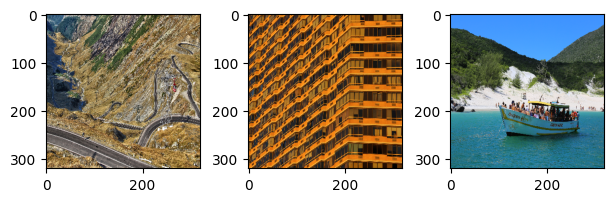

In [ ]:

plt.figure(figsize=(10, 2))
for i in range(1,4):
    ax = plt.subplot(1, 4, i)
    image_rgb = cv2.cvtColor(y_test[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb.reshape(SIZE, SIZE,3))
plt.show()

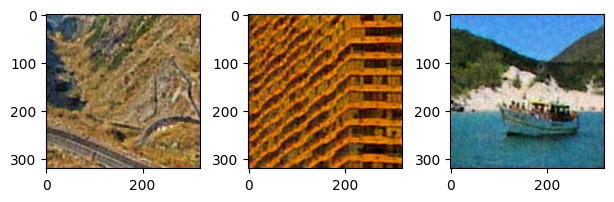

In [ ]:
plt.figure(figsize=(10, 2))
for i in range(1,4):
    ax = plt.subplot(1, 4, i)
    image_rgb = cv2.cvtColor(no_noise_img[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb.reshape(SIZE, SIZE,3))
plt.show()

In [ ]:
psnr_score = psnr(y_test, model.predict(x_test)).numpy()
print("PSNR Score:", psnr_score)

5/5 [==============================] - 0s 64ms/step
PSNR Score: 19.775936


In [ ]:
psnr1 = psnr(y_test, x_test).numpy()
print(psnr1)

14.15156
